In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

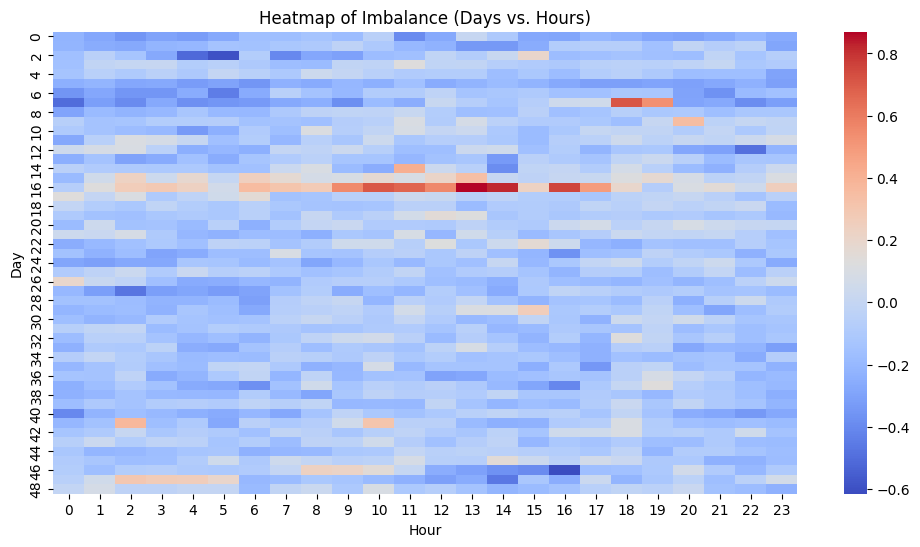

In [ ]:
X = np.load("../data/X.npy")

condition = X[:, :3, :]
target = X[:, 3, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 3 * 24
target_dim = 24
latent_dim = 16

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

plt.figure(figsize=(12, 6))
sns.heatmap(target, cmap='coolwarm', annot=False)
plt.xlabel("Hour")
plt.ylabel("Day")
plt.title("Heatmap of Imbalance")
plt.show()

In [45]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + target_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
    
    def forward(self, cond, target):
        # cond: (batch_size, 72) ; target: (batch_size, 24)
        x = torch.cat([cond, target], dim=1)  # shape: (batch_size, 96)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [46]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, target_dim)
    
    def forward(self, cond, z):
        # cond: (batch_size, 72); z: (batch_size, latent_dim)
        x = torch.cat([cond, z], dim=1)  # shape: (batch_size, 72 + latent_dim)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        out = self.fc3(h)  # predicted target, shape: (batch_size, 24)
        return out

In [47]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim)
    
    def reparameterize(self, mu, logvar):
        # Clamp logvar to prevent numerical issues
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)
        z = self.reparameterize(mu, logvar)
        recon_target = self.decoder(cond, z)
        return recon_target, mu, logvar

In [48]:
def loss_function(recon_target, target, mu, logvar):
    recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [52]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)   # shape: (batch, 3, 24)
        batch_target = batch_target.to(device)  # shape: (batch, 24)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)  # shape: (batch, 72)
        
        optimizer.zero_grad()
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss = loss_function(recon_target, batch_target, mu, logvar)
        loss.backward()
        # Optional: gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * batch_cond.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            recon_target, mu, logvar = model(batch_cond_flat, batch_target)
            loss = loss_function(recon_target, batch_target, mu, logvar)
            val_loss += loss.item() * batch_cond.size(0)
    avg_val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/100, Train Loss: 0.0144, Val Loss: 0.0253
Epoch 2/100, Train Loss: 0.0143, Val Loss: 0.0258
Epoch 3/100, Train Loss: 0.0142, Val Loss: 0.0257
Epoch 4/100, Train Loss: 0.0147, Val Loss: 0.0243
Epoch 5/100, Train Loss: 0.0142, Val Loss: 0.0248
Epoch 6/100, Train Loss: 0.0145, Val Loss: 0.0263
Epoch 7/100, Train Loss: 0.0145, Val Loss: 0.0248
Epoch 8/100, Train Loss: 0.0140, Val Loss: 0.0250
Epoch 9/100, Train Loss: 0.0145, Val Loss: 0.0255
Epoch 10/100, Train Loss: 0.0140, Val Loss: 0.0250
Epoch 11/100, Train Loss: 0.0139, Val Loss: 0.0261
Epoch 12/100, Train Loss: 0.0139, Val Loss: 0.0254
Epoch 13/100, Train Loss: 0.0139, Val Loss: 0.0239
Epoch 14/100, Train Loss: 0.0141, Val Loss: 0.0239
Epoch 15/100, Train Loss: 0.0138, Val Loss: 0.0255
Epoch 16/100, Train Loss: 0.0136, Val Loss: 0.0258
Epoch 17/100, Train Loss: 0.0137, Val Loss: 0.0241
Epoch 18/100, Train Loss: 0.0140, Val Loss: 0.0252
Epoch 19/100, Train Loss: 0.0140, Val Loss: 0.0255
Epoch 20/100, Train Loss: 0.0136, Val Lo

In [ ]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    recon_target, _, _ = model(sample_cond_flat, sample_target)
    print("\nValidation Sample:")
    print("True Imbalance (first sample):")
    print(sample_target[0])
    print("Predicted Imbalance (first sample):")
    print(recon_target[0])

    


Validation Sample:
True Imbalance (first sample):
tensor([-0.2400, -0.2200, -0.2830, -0.2690, -0.3250, -0.2970, -0.3520, -0.2350,
        -0.2640, -0.2070, -0.2400, -0.1530, -0.2560, -0.2230, -0.1830, -0.2210,
        -0.2690, -0.3110, -0.3120, -0.2930, -0.3060, -0.2740, -0.2370, -0.3080])
Predicted Imbalance (first sample):
tensor([-0.1412,  0.0689, -0.1466, -0.1934, -0.2332, -0.2153, -0.1215, -0.0310,
        -0.0459, -0.0034,  0.0167, -0.2302, -0.1247, -0.0184, -0.5338,  0.0172,
        -0.4579, -0.2455,  0.2528, -0.2259, -0.2767, -0.4022, -0.4644, -0.0763])
